Cell 1: Activation cell

In [5]:
import sys
from pathlib import Path
import os

# --- Resolve project root safely from a notebook ---
PROJECT_ROOT = Path(os.getcwd()).resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# Add project root to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)

# --- Imports from src ---
from src.train import train_model

# --- Data directory ---
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "EuroSAT_RGB"
print("Data dir:", DATA_DIR)

# --- Train model ---
model, class_names = train_model(
    data_dir=DATA_DIR,
    epochs=5
)

Project root: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model
Data dir: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\data\raw\EuroSAT_RGB
Using device: cpu


Epoch 1/5: 100%|██████████| 296/296 [09:31<00:00,  1.93s/it]


Epoch 1 | Train Loss: 1.2261 | Val Acc: 0.6440
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\simple_cnn_v2.pth (val_acc=0.6440)


Epoch 2/5: 100%|██████████| 296/296 [04:00<00:00,  1.23it/s]


Epoch 2 | Train Loss: 0.8666 | Val Acc: 0.7593
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\simple_cnn_v2.pth (val_acc=0.7593)


Epoch 3/5: 100%|██████████| 296/296 [04:32<00:00,  1.09it/s]


Epoch 3 | Train Loss: 0.7777 | Val Acc: 0.7484


Epoch 4/5: 100%|██████████| 296/296 [04:16<00:00,  1.15it/s]


Epoch 4 | Train Loss: 0.7111 | Val Acc: 0.6901


Epoch 5/5: 100%|██████████| 296/296 [10:29<00:00,  2.13s/it]   


Epoch 5 | Train Loss: 0.6609 | Val Acc: 0.8180
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\simple_cnn_v2.pth (val_acc=0.8180)
Done. Best Val Acc: 0.8180


Cell 2: Load saved model and run test evaluation

In [6]:
import torch
from pathlib import Path

from src.dataset import load_eurosat_dataset
from src.models import build_model
from src.eval import evaluate_model

device = "cuda" if torch.cuda.is_available() else "cpu"

# repo root from notebook (assumes notebook is in /notebooks)
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

MODEL_PATH = PROJECT_ROOT / "models" / "simple_cnn_v2.pth"
print("Loading weights from:", MODEL_PATH)

# Reload loaders (same splits as before if seed is same)
train_loader, val_loader, test_loader, class_names = load_eurosat_dataset(
    data_dir=DATA_DIR,
    img_size=64,
    batch_size=64,
    seed=42
)

# Build model
model = build_model(num_classes=len(class_names)).to(device)

# Load weights with a helpful error if mismatch happens
state = torch.load(MODEL_PATH, map_location=device)
try:
    model.load_state_dict(state)
except RuntimeError as e:
    raise RuntimeError(
        f"State dict mismatch. Did you train with a different model version?\n"
        f"Model path: {MODEL_PATH}\n"
        f"Try retraining OR make sure models.py matches the checkpoint.\n\n"
        f"Original error:\n{e}"
    )

model.eval()

test_acc, cm, report = evaluate_model(model, test_loader, class_names, device)

print("Test Accuracy:", round(test_acc, 4))
print(report)

Loading weights from: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\simple_cnn_v2.pth
Test Accuracy: 0.8094
                      precision    recall  f1-score   support

          AnnualCrop     0.8257    0.8432    0.8344       472
              Forest     0.9589    0.8982    0.9276       442
HerbaceousVegetation     0.7755    0.6638    0.7153       458
             Highway     0.6582    0.5959    0.6255       391
          Industrial     0.9691    0.8307    0.8946       378
             Pasture     0.8136    0.7592    0.7855       299
       PermanentCrop     0.6854    0.7071    0.6961       379
         Residential     0.8327    0.9844    0.9022       450
               River     0.6921    0.7973    0.7410       375
             SeaLake     0.8778    0.9729    0.9229       406

            accuracy                         0.8094      4050
           macro avg     0.8089    0.8053    0.8045      4050
        weighted avg     0.8114    0.8094    0.8078      4050



Cell 3: Confusion matrix

Saved: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\reports\figures\confusion_matrix_v2_normalized.png


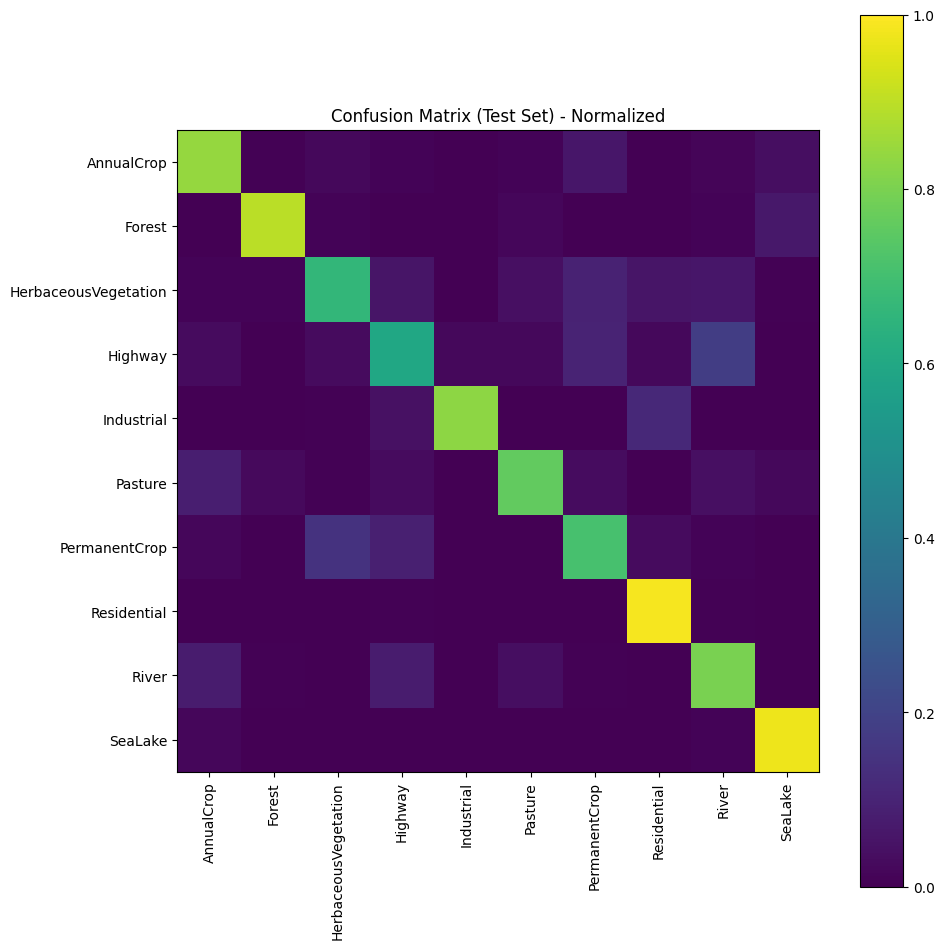

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

fig_dir = PROJECT_ROOT / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

cm_np = np.array(cm)

# Normalize rows (each true class sums to 1)
cm_norm = cm_np / np.maximum(cm_np.sum(axis=1, keepdims=True), 1)

plt.figure(figsize=(10, 10))
plt.imshow(cm_norm, vmin=0, vmax=1)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title("Confusion Matrix (Test Set) - Normalized")
plt.colorbar()
plt.tight_layout()

out_path = fig_dir / "confusion_matrix_v2_normalized.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", out_path)

plt.show()

Cell 4: Raw Confusion Matrix

Saved: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\reports\figures\confusion_matrix_v2_raw.png


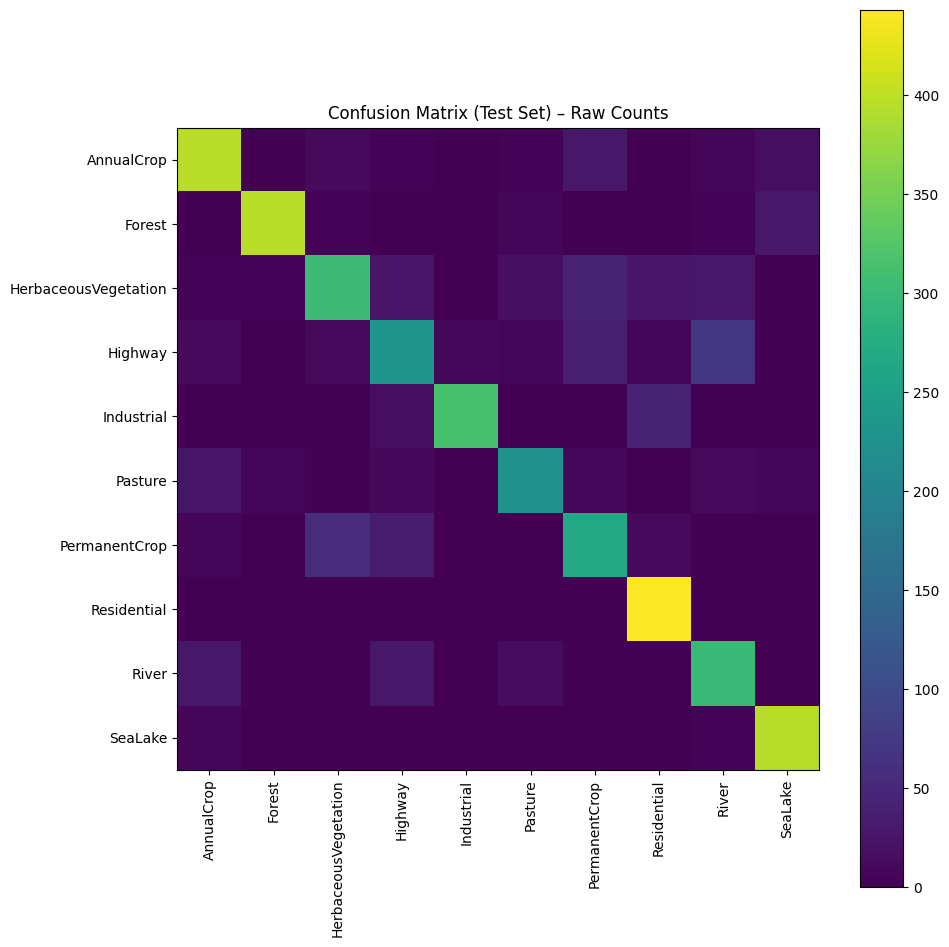

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

fig_dir = PROJECT_ROOT / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

cm_np = np.array(cm)

plt.figure(figsize=(10, 10))
plt.imshow(cm_np)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title("Confusion Matrix (Test Set) – Raw Counts")
plt.colorbar()
plt.tight_layout()

out_path = fig_dir / "confusion_matrix_v2_raw.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", out_path)

plt.show()